## Package

In [1]:
!pip install fastai -Uqq

     |████████████████████████████████| 197 kB 32.9 MB/s 
     |████████████████████████████████| 60 kB 10.1 MB/s 


In [2]:
from fastai.vision.all import *

## Arch Details

Body and Head: The "head" of a neural net is the part that is specialized for a particular task. For a CNN, it's generally the part after the adaptive average pooling layer. The "body" is everything else, and includes the "stem"

### Computer Vision

In [3]:
model_meta[resnet50]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [4]:
create_head(50, 2)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=100, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [5]:
create_head(20, 4, bn_final = True, lin_first=True, concat_pool = False)

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=20, out_features=512, bias=False)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=512, out_features=4, bias=True)
  (8): BatchNorm1d(4, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
)

### Siamese Network

In [6]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [49]:
class SiameseImage(fastuple):

  def show(self, ctx = None, **kwargs):
    if len(self) > 2:
      img1, img2, similarity = self
    else:
      img1, img2 = self
      similarity = 'Undetermined'
  
    if not isinstance(img1, Tensor):
      if img2.size != img1.size: img2 = img2.resize(img1.size)
      t1, t2 = tensor(img1), tensor(img2)
      t1, t2 = t1.permute(2, 0, 1), t2.permute(2, 0, 1)
    else: t1, t2 = img1, img2
    line = t1.new_zeros(t1.shape[0], t1.shape[1], 20)
    return show_image(torch.cat([t1, line, t2], dim=2), title=similarity, ctx = ctx)

In [50]:
def label_func(fname):
  return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [51]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

In [52]:
splits = RandomSplitter()(files)

In [53]:
tfm = SiameseTransform(files, label_func, splits)

In [54]:
tls = TfmdLists(files, tfm, splits=splits)

In [55]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [56]:
class SiameseModel(Module):
  def __init__(self, encoder, head):
    self.encoder = encoder
    self.head = head

  def forward(self, x1, x2):
    ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim = 1)
    return self.head(ftrs)

In [57]:
encoder = create_body(resnet34, cut=-2)

In [58]:
head = create_head(512*2, 2, ps=0.5)

In [59]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [60]:
model = SiameseModel(encoder, head)

In [61]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss()(out, targ.long())

In [62]:
def siamese_splitter(model):
  return [params(model.encoder), params(model.head)]

In [63]:
learn = Learner(dls, model, loss_func=loss_func, splitter=siamese_splitter, metrics=accuracy)

In [64]:
learn.freeze()

In [65]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.549689,0.366333,0.839648,01:35
1,0.388682,0.250383,0.901218,01:35
2,0.289647,0.204684,0.922869,01:35
3,0.250566,0.186805,0.926252,01:34


In [66]:
learn.unfreeze()

In [67]:
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.236278,0.180264,0.927605,01:40
1,0.228568,0.176572,0.933694,01:40
2,0.225842,0.173531,0.935724,01:39
3,0.223671,0.177745,0.932341,01:39


In [215]:
@patch
def predict_with_show(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item)[0]
    act = nn.Sigmoid()(res)
    res = torch.argmax(act)
    if res == tensor(0):
        per = torch.round(act[res])
        SiameseImage(item[0], item[1], f'Prediction: Not similar {per} %').show()
    else:
        per = torch.round(act[res])
        SiameseImage(item[0], item[1], f'Prediction: Similar {per} %').show()

In [227]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[200])

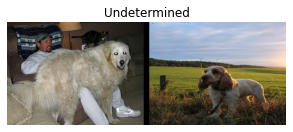

In [228]:
sample = SiameseImage(imgval, imgtest)

sample.show();

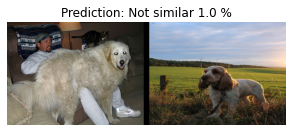

In [229]:
learn.predict_with_show(sample)